In [6]:
from google.colab import drive
import pandas as pd

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

# Update the file path to the location where you uploaded your CSV in Google Drive
file_path = '/content/drive/My Drive/Thesis/df-englisch_cat.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Drop the first column (if it's an unwanted index column)
df = df.drop(df.columns[0], axis=1)

# Display the column names
df.columns.tolist()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['ada_embedding_eng',
 'numerical_price',
 'num_bedrooms',
 'num_rooms',
 'building_type_Bestaande bouw',
 'building_type_Nieuwbouw',
 'building_type_na',
 'tag_k.k.',
 'tag_v.o.n.',
 'house_category_Appartement',
 'house_category_Bungalow',
 'house_category_Eengezinswoning',
 'house_category_Grachtenpand',
 'house_category_Herenhuis',
 'house_category_Landhuis',
 'house_category_Other',
 'house_category_Unknown',
 'house_category_Villa',
 'house_category_Woonboerderij',
 'house_category_Woonboot',
 'energy_label_encoded',
 'size_scaled',
 'longitude_scaled',
 'latitude_scaled']

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Extract 'numerical_price' as target variable
y = df['numerical_price']

# Dropping the 'ada_embedding_eng' and 'numerical_price' columns from df
x = df.drop(["ada_embedding_eng", "numerical_price"], axis=1)

# First split: separate out a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]

In [8]:
!pip install optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_nn_cat(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=False)
    neurons_layer_1 = trial.suggest_int("neurons_layer_1", 16, 1024, step=16)
    neurons_layer_2 = trial.suggest_int("neurons_layer_2", 16, 512, step=16)
    neurons_layer_3 = trial.suggest_int("neurons_layer_3", 16, 256, step=16)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 5, 100)
    regularization = trial.suggest_categorical("regularization", ["none", "l1", "l2", "l1_l2"])
    l1_reg = trial.suggest_float("l1_reg", 1e-5, 1e-1, log=True) if regularization in ["l1", "l1_l2"] else 0
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-1, log=True) if regularization in ["l2", "l1_l2"] else 0

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]



        # Build model
        model = Sequential()
        model.add(Dense(neurons_layer_1, activation='relu', input_shape=(X_train_fold.shape[1],),
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_2, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_3, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(1, activation='linear'))

        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Scaling y_train
        scaler = StandardScaler()
        y_train_scaled = scaler.fit_transform(y_train_fold.reshape(-1, 1)).flatten()

        # Train model
        model.fit(X_train_fold, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred_scaled = model.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return np.mean(r2_scores)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print("Adjusted y_train shape:", y_train.shape)
print("Adjusted y_test shape:", y_test.shape)

study_NN = optuna.create_study(directions=['maximize'])
study_NN.optimize(Objective_nn_cat, n_trials=50)

[I 2024-01-06 11:47:56,730] A new study created in memory with name: no-name-2a8b418c-343a-4934-9ae6-dc758d7c23a6


Adjusted y_train shape: (10000,)
Adjusted y_test shape: (14403,)
63/63 [==============================] - 1s 1ms/step


[I 2024-01-06 11:51:30,099] Trial 0 finished with value: 0.6435262305996144 and parameters: {'learning_rate': 0.004107876941640211, 'neurons_layer_1': 672, 'neurons_layer_2': 384, 'neurons_layer_3': 96, 'batch_size': 32, 'epochs': 63, 'regularization': 'l2', 'l2_reg': 0.0009604583972135398}. Best is trial 0 with value: 0.6435262305996144.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 11:52:52,260] Trial 1 finished with value: 0.6188354310745743 and parameters: {'learning_rate': 0.0024960429356674146, 'neurons_layer_1': 448, 'neurons_layer_2': 400, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 78, 'regularization': 'l1', 'l1_reg': 0.004163940182904386}. Best is trial 0 with value: 0.6435262305996144.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 11:54:36,098] Trial 2 finished with value: 0.617613257324828 and parameters: {'learning_rate': 0.00985183679563499, 'neurons_layer_1': 320, 'neurons_layer_2': 464, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 34, 'regularization': 'none'}. Best is trial 0 with value: 0.6435262305996144.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 11:58:01,250] Trial 3 finished with value: -0.0003335431603841421 and parameters: {'learning_rate': 0.00011937651631118505, 'neurons_layer_1': 576, 'neurons_layer_2': 272, 'neurons_layer_3': 192, 'batch_size': 32, 'epochs': 66, 'regularization': 'l1_l2', 'l1_reg': 0.07761489409348706, 'l2_reg': 0.05011545133580592}. Best is trial 0 with value: 0.6435262305996144.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 11:59:10,627] Trial 4 finished with value: -0.0003017443717009627 and parameters: {'learning_rate': 0.0028713016876085857, 'neurons_layer_1': 368, 'neurons_layer_2': 400, 'neurons_layer_3': 160, 'batch_size': 128, 'epochs': 66, 'regularization': 'l1', 'l1_reg': 0.051155498432491925}. Best is trial 0 with value: 0.6435262305996144.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:03:12,049] Trial 5 finished with value: 0.6579547535803376 and parameters: {'learning_rate': 0.0009539026094867227, 'neurons_layer_1': 976, 'neurons_layer_2': 272, 'neurons_layer_3': 128, 'batch_size': 16, 'epochs': 38, 'regularization': 'l1_l2', 'l1_reg': 1.9981685749991345e-05, 'l2_reg': 8.304877865197816e-05}. Best is trial 5 with value: 0.6579547535803376.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:04:19,169] Trial 6 finished with value: 0.635255694134842 and parameters: {'learning_rate': 0.009876902234986096, 'neurons_layer_1': 864, 'neurons_layer_2': 32, 'neurons_layer_3': 176, 'batch_size': 64, 'epochs': 55, 'regularization': 'l2', 'l2_reg': 0.000888211512090455}. Best is trial 5 with value: 0.6579547535803376.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:08:59,150] Trial 7 finished with value: 0.6500348007854907 and parameters: {'learning_rate': 0.002902251787291831, 'neurons_layer_1': 928, 'neurons_layer_2': 176, 'neurons_layer_3': 160, 'batch_size': 32, 'epochs': 96, 'regularization': 'l1', 'l1_reg': 6.791954468912192e-05}. Best is trial 5 with value: 0.6579547535803376.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:10:40,049] Trial 8 finished with value: 0.592404280750522 and parameters: {'learning_rate': 0.003325324644222871, 'neurons_layer_1': 336, 'neurons_layer_2': 64, 'neurons_layer_3': 80, 'batch_size': 64, 'epochs': 99, 'regularization': 'none'}. Best is trial 5 with value: 0.6579547535803376.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 12:15:06,647] Trial 9 finished with value: 0.615408873886943 and parameters: {'learning_rate': 0.009509597865949609, 'neurons_layer_1': 336, 'neurons_layer_2': 448, 'neurons_layer_3': 224, 'batch_size': 32, 'epochs': 87, 'regularization': 'none'}. Best is trial 5 with value: 0.6579547535803376.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:15:31,257] Trial 10 finished with value: 0.6226571864122605 and parameters: {'learning_rate': 0.006491117706438225, 'neurons_layer_1': 80, 'neurons_layer_2': 272, 'neurons_layer_3': 48, 'batch_size': 16, 'epochs': 6, 'regularization': 'l1_l2', 'l1_reg': 1.4493012928458913e-05, 'l2_reg': 1.671885438098099e-05}. Best is trial 5 with value: 0.6579547535803376.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:18:32,817] Trial 11 finished with value: 0.5969456614539498 and parameters: {'learning_rate': 0.0014804542377435015, 'neurons_layer_1': 1024, 'neurons_layer_2': 176, 'neurons_layer_3': 16, 'batch_size': 16, 'epochs': 34, 'regularization': 'l1', 'l1_reg': 2.0014360693318043e-05}. Best is trial 5 with value: 0.6579547535803376.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:22:05,765] Trial 12 finished with value: 0.598308335044179 and parameters: {'learning_rate': 0.005633164614490888, 'neurons_layer_1': 1008, 'neurons_layer_2': 176, 'neurons_layer_3': 240, 'batch_size': 16, 'epochs': 37, 'regularization': 'l1_l2', 'l1_reg': 0.00015615632729890503, 'l2_reg': 1.4839004289457073e-05}. Best is trial 5 with value: 0.6579547535803376.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:23:40,749] Trial 13 finished with value: 0.6645923838485392 and parameters: {'learning_rate': 0.00031660364824151585, 'neurons_layer_1': 800, 'neurons_layer_2': 160, 'neurons_layer_3': 112, 'batch_size': 16, 'epochs': 17, 'regularization': 'l1', 'l1_reg': 0.00020520074950360244}. Best is trial 13 with value: 0.6645923838485392.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:24:30,180] Trial 14 finished with value: 0.614895438654097 and parameters: {'learning_rate': 0.000199483266905921, 'neurons_layer_1': 784, 'neurons_layer_2': 96, 'neurons_layer_3': 112, 'batch_size': 16, 'epochs': 10, 'regularization': 'l1_l2', 'l1_reg': 0.0005370525513124101, 'l2_reg': 0.0001549921440406321}. Best is trial 13 with value: 0.6645923838485392.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:26:55,771] Trial 15 finished with value: 0.6611300947442194 and parameters: {'learning_rate': 0.0014635685905276122, 'neurons_layer_1': 768, 'neurons_layer_2': 320, 'neurons_layer_3': 80, 'batch_size': 16, 'epochs': 24, 'regularization': 'l1', 'l1_reg': 0.0009503417239500482}. Best is trial 13 with value: 0.6645923838485392.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:28:50,041] Trial 16 finished with value: 0.6111406626956072 and parameters: {'learning_rate': 0.0016254424933832938, 'neurons_layer_1': 688, 'neurons_layer_2': 336, 'neurons_layer_3': 64, 'batch_size': 16, 'epochs': 19, 'regularization': 'l1', 'l1_reg': 0.003443144424101152}. Best is trial 13 with value: 0.6645923838485392.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:30:35,645] Trial 17 finished with value: 0.590839010414445 and parameters: {'learning_rate': 0.007428497460796984, 'neurons_layer_1': 800, 'neurons_layer_2': 128, 'neurons_layer_3': 32, 'batch_size': 16, 'epochs': 21, 'regularization': 'l1', 'l1_reg': 0.0007212459351716956}. Best is trial 13 with value: 0.6645923838485392.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:32:50,331] Trial 18 finished with value: 0.5635847559129095 and parameters: {'learning_rate': 0.004638483723780312, 'neurons_layer_1': 624, 'neurons_layer_2': 320, 'neurons_layer_3': 80, 'batch_size': 16, 'epochs': 23, 'regularization': 'l1', 'l1_reg': 0.003701580235523032}. Best is trial 13 with value: 0.6645923838485392.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:33:33,859] Trial 19 finished with value: 0.6615072999785239 and parameters: {'learning_rate': 0.0019479395105455265, 'neurons_layer_1': 784, 'neurons_layer_2': 192, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 42, 'regularization': 'l1', 'l1_reg': 0.00016363774418517155}. Best is trial 13 with value: 0.6645923838485392.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:34:08,644] Trial 20 finished with value: 0.5366909500432029 and parameters: {'learning_rate': 0.003917096783942408, 'neurons_layer_1': 96, 'neurons_layer_2': 208, 'neurons_layer_3': 112, 'batch_size': 128, 'epochs': 47, 'regularization': 'l2', 'l2_reg': 0.08655243055571181}. Best is trial 13 with value: 0.6645923838485392.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:34:38,950] Trial 21 finished with value: 0.665021340388406 and parameters: {'learning_rate': 0.0017586331412866377, 'neurons_layer_1': 752, 'neurons_layer_2': 224, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 26, 'regularization': 'l1', 'l1_reg': 0.000186981138153666}. Best is trial 21 with value: 0.665021340388406.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:35:22,858] Trial 22 finished with value: 0.6580871492094642 and parameters: {'learning_rate': 0.0009938533113816519, 'neurons_layer_1': 512, 'neurons_layer_2': 224, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 44, 'regularization': 'l1', 'l1_reg': 0.00015126295361194843}. Best is trial 21 with value: 0.665021340388406.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:35:40,032] Trial 23 finished with value: 0.652508318379254 and parameters: {'learning_rate': 0.002206693848141208, 'neurons_layer_1': 896, 'neurons_layer_2': 112, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 14, 'regularization': 'l1', 'l1_reg': 0.00018405551123323383}. Best is trial 21 with value: 0.665021340388406.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:36:14,288] Trial 24 finished with value: 0.6757784895887875 and parameters: {'learning_rate': 0.0005633164410523861, 'neurons_layer_1': 720, 'neurons_layer_2': 224, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 31, 'regularization': 'l1', 'l1_reg': 7.098332460836312e-05}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:36:44,438] Trial 25 finished with value: 0.6537097475907621 and parameters: {'learning_rate': 0.0008764630690425768, 'neurons_layer_1': 688, 'neurons_layer_2': 240, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 29, 'regularization': 'l1', 'l1_reg': 6.603308254007187e-05}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:37:02,955] Trial 26 finished with value: 0.6566505908471555 and parameters: {'learning_rate': 0.00022735517058558672, 'neurons_layer_1': 848, 'neurons_layer_2': 144, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 15, 'regularization': 'l1', 'l1_reg': 5.4607335588959874e-05}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:37:39,565] Trial 27 finished with value: 0.6514158648170111 and parameters: {'learning_rate': 0.0008256167815709166, 'neurons_layer_1': 576, 'neurons_layer_2': 80, 'neurons_layer_3': 48, 'batch_size': 64, 'epochs': 27, 'regularization': 'l1', 'l1_reg': 0.00038773420707359507}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:38:26,043] Trial 28 finished with value: 0.6254910582554581 and parameters: {'learning_rate': 0.0035740991684280123, 'neurons_layer_1': 720, 'neurons_layer_2': 144, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 50, 'regularization': 'l2', 'l2_reg': 0.011662211509853585}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 12:39:28,800] Trial 29 finished with value: 0.6431190051732656 and parameters: {'learning_rate': 0.0048923429024906465, 'neurons_layer_1': 480, 'neurons_layer_2': 512, 'neurons_layer_3': 112, 'batch_size': 128, 'epochs': 54, 'regularization': 'none'}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:39:43,010] Trial 30 finished with value: 0.5720145645881308 and parameters: {'learning_rate': 0.008815378145225426, 'neurons_layer_1': 608, 'neurons_layer_2': 240, 'neurons_layer_3': 64, 'batch_size': 64, 'epochs': 6, 'regularization': 'l2', 'l2_reg': 0.006993100231383501}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:40:26,882] Trial 31 finished with value: 0.6740166856636713 and parameters: {'learning_rate': 0.0019680581278159874, 'neurons_layer_1': 752, 'neurons_layer_2': 192, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 43, 'regularization': 'l1', 'l1_reg': 0.0002154639814912126}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:41:02,639] Trial 32 finished with value: 0.6466750586601664 and parameters: {'learning_rate': 0.0022957603731676556, 'neurons_layer_1': 736, 'neurons_layer_2': 304, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 29, 'regularization': 'l1', 'l1_reg': 0.0002716907815875289}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:42:14,024] Trial 33 finished with value: 0.6458370591763777 and parameters: {'learning_rate': 0.001374690154984576, 'neurons_layer_1': 848, 'neurons_layer_2': 352, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 59, 'regularization': 'l1', 'l1_reg': 3.626570161695344e-05}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:42:49,543] Trial 34 finished with value: 0.6634338366043674 and parameters: {'learning_rate': 0.0027488146009103996, 'neurons_layer_1': 656, 'neurons_layer_2': 160, 'neurons_layer_3': 128, 'batch_size': 128, 'epochs': 34, 'regularization': 'l1', 'l1_reg': 0.001942925808767117}. Best is trial 24 with value: 0.6757784895887875.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:43:55,465] Trial 35 finished with value: 0.6788589419577507 and parameters: {'learning_rate': 0.0001481458629411212, 'neurons_layer_1': 416, 'neurons_layer_2': 208, 'neurons_layer_3': 80, 'batch_size': 128, 'epochs': 72, 'regularization': 'l1', 'l1_reg': 9.650241971828681e-05}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:44:49,937] Trial 36 finished with value: 0.6727456268429988 and parameters: {'learning_rate': 0.0006513523860543942, 'neurons_layer_1': 224, 'neurons_layer_2': 256, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 72, 'regularization': 'l1', 'l1_reg': 8.206899835644611e-05}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:45:44,966] Trial 37 finished with value: 0.6309254267359086 and parameters: {'learning_rate': 0.0005699132873156609, 'neurons_layer_1': 192, 'neurons_layer_2': 288, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 74, 'regularization': 'none'}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:46:45,644] Trial 38 finished with value: 0.6607205362299483 and parameters: {'learning_rate': 0.001079118814273287, 'neurons_layer_1': 240, 'neurons_layer_2': 368, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 72, 'regularization': 'l1', 'l1_reg': 8.250091593583464e-05}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:50:40,586] Trial 39 finished with value: 0.6376797880622609 and parameters: {'learning_rate': 0.0022520652210014937, 'neurons_layer_1': 448, 'neurons_layer_2': 256, 'neurons_layer_3': 80, 'batch_size': 32, 'epochs': 84, 'regularization': 'l1', 'l1_reg': 3.0291496319288072e-05}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:51:25,882] Trial 40 finished with value: 0.6570302110104643 and parameters: {'learning_rate': 0.000770336089306592, 'neurons_layer_1': 240, 'neurons_layer_2': 208, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 64, 'regularization': 'l2', 'l2_reg': 0.005420076724955783}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:52:21,475] Trial 41 finished with value: 0.6343143619923486 and parameters: {'learning_rate': 0.0016783682973109178, 'neurons_layer_1': 416, 'neurons_layer_2': 224, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 59, 'regularization': 'l1', 'l1_reg': 0.00010165126002619123}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:53:43,345] Trial 42 finished with value: 0.6516328957374218 and parameters: {'learning_rate': 0.0030032107950520486, 'neurons_layer_1': 544, 'neurons_layer_2': 256, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 82, 'regularization': 'l1', 'l1_reg': 4.071394166716645e-05}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:54:34,581] Trial 43 finished with value: 0.6539516568527943 and parameters: {'learning_rate': 0.0018454202901209535, 'neurons_layer_1': 144, 'neurons_layer_2': 288, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 71, 'regularization': 'l1', 'l1_reg': 0.00034688797587345495}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:55:49,243] Trial 44 finished with value: 0.6738395860213657 and parameters: {'learning_rate': 0.00013093685243862555, 'neurons_layer_1': 272, 'neurons_layer_2': 208, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 94, 'regularization': 'l1', 'l1_reg': 9.869134861535499e-05}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 12:59:20,817] Trial 45 finished with value: 0.6581029131932634 and parameters: {'learning_rate': 0.0002826991720355634, 'neurons_layer_1': 288, 'neurons_layer_2': 192, 'neurons_layer_3': 208, 'batch_size': 32, 'epochs': 89, 'regularization': 'l1_l2', 'l1_reg': 8.784964632091946e-05, 'l2_reg': 0.0001698116698886279}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:00:10,633] Trial 46 finished with value: 0.6533626208510732 and parameters: {'learning_rate': 0.0005661323233880646, 'neurons_layer_1': 384, 'neurons_layer_2': 16, 'neurons_layer_3': 80, 'batch_size': 128, 'epochs': 92, 'regularization': 'none'}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:01:20,969] Trial 47 finished with value: 0.6653656686186766 and parameters: {'learning_rate': 0.00018820015557073497, 'neurons_layer_1': 272, 'neurons_layer_2': 192, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 97, 'regularization': 'l1', 'l1_reg': 1.1350747080204357e-05}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:03:05,955] Trial 48 finished with value: 0.5265220157937052 and parameters: {'learning_rate': 0.0012939489032862215, 'neurons_layer_1': 352, 'neurons_layer_2': 272, 'neurons_layer_3': 80, 'batch_size': 64, 'epochs': 68, 'regularization': 'l1', 'l1_reg': 0.014683153020778616}. Best is trial 35 with value: 0.6788589419577507.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:04:16,029] Trial 49 finished with value: 0.6285900390780936 and parameters: {'learning_rate': 0.0006180851111955035, 'neurons_layer_1': 144, 'neurons_layer_2': 400, 'neurons_layer_3': 176, 'batch_size': 128, 'epochs': 78, 'regularization': 'l1_l2', 'l1_reg': 0.00010836419273184759, 'l2_reg': 0.021320399973733167}. Best is trial 35 with value: 0.6788589419577507.


<ipython-input-9-adb073d63f88>:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_NN)
<ipython-input-9-adb073d63f88>:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_NN)
<ipython-input-9-adb073d63f88>:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_NN)


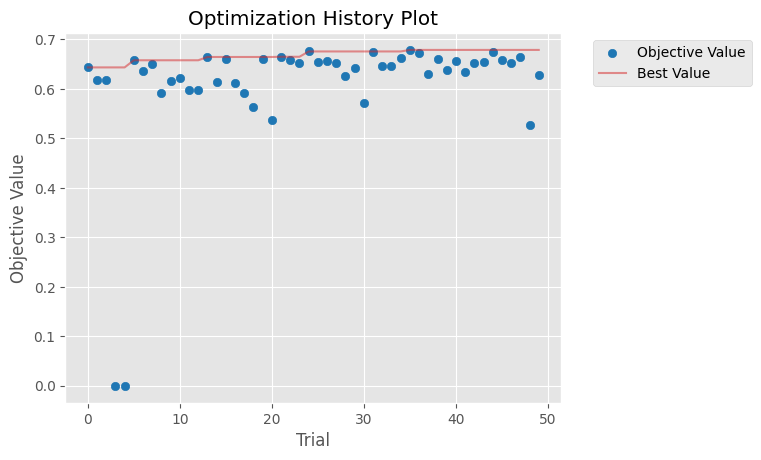

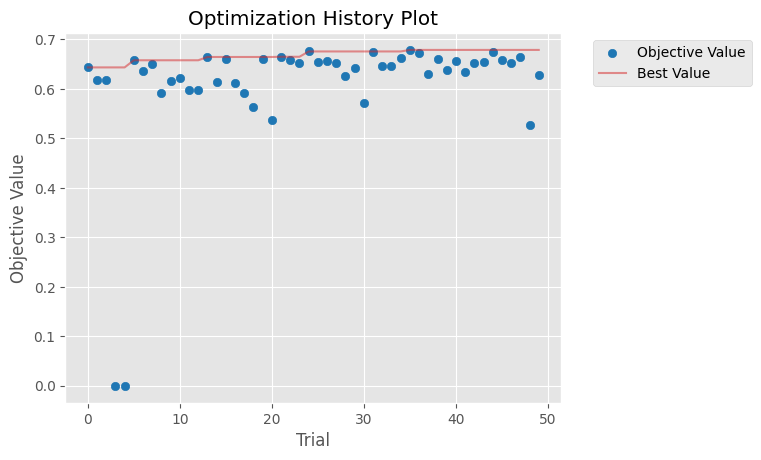

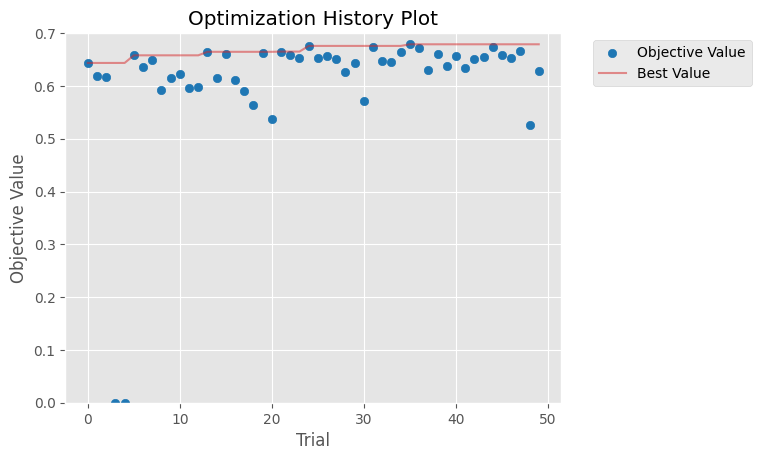

In [9]:

from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
optuna.visualization.matplotlib.plot_optimization_history(study_NN)

optuna.visualization.matplotlib.plot_optimization_history(study_NN)

optuna_matplotlib.plot_optimization_history(study_NN)

plt.ylim(0, 0.7)

plt.show()